# Mini Project 4

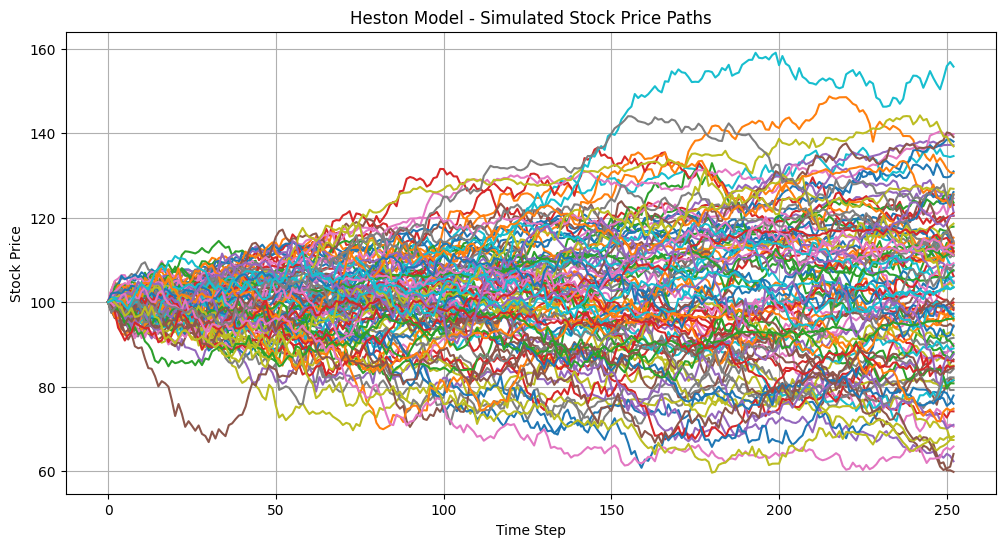

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulate_heston_paths(S0, v0, kappa, theta, sigma_v, rho, r, T, N, M):
    dt = T/N
    S = np.zeros((M, N+1))
    v = np.zeros((M, N+1))
    S[:, 0] = S0
    v[:, 0] = v0

    for t in range(1, N+1):
        Z1 = np.random.normal(size=M)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(size=M)

        v[:, t] = np.abs(v[:, t-1] + kappa * (theta - v[:, t-1]) * dt + sigma_v * np.sqrt(v[:, t-1] * dt)*Z2)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * v[:, t-1]) * dt + np.sqrt(v[:, t-1] *dt) * Z1)

    return S, v

#Parameters
S0 = 100
v0 = 0.04
kappa = 2.0
theta = 0.04
sigma_v = 0.3
rho = -0.7
r = 0.03
T = 1
N = 252
M = 100

#Simulate paths
S_paths, v_paths = simulate_heston_paths(S0, v0, kappa, theta, sigma_v, rho, r, T, N, M)

#Plot simulated stock price paths
plt.figure(figsize=(12,6))

for i in range(M):
    plt.plot(S_paths[i])
plt.title("Heston Model - Simulated Stock Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.grid(True)
plt.show()


C:\Users\andre\AppData\Local\Temp\ipykernel_53308\2841759563.py:9: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


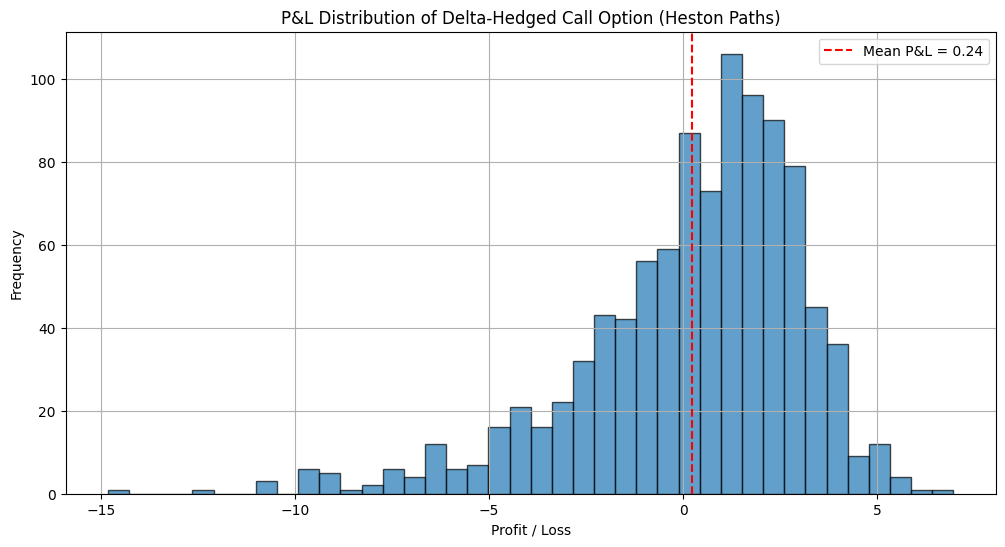

In [2]:
def bs_call_price(S, K, sigma, t, r):
    sigma = np.maximum(sigma, 1e-8)
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return S * norm.cdf(d1) - K * np.exp(-r*t) * norm.cdf(d2)

def bs_delta_call(S, K, sigma, t, r):
    sigma = np.maximum(sigma, 1e-8)
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    return norm.cdf(d1)

#Heston model delta hedge

def delta_hedging_heston(S_paths, v_paths, K, r, T, rebalance_steps):
    M, N_plus_1 = S_paths.shape
    N = N_plus_1 - 1
    dt = T / N
    rebalance_indices = np.linspace(0, N, rebalance_steps, dtype = int)

    option_premium = bs_call_price(S_paths[:, 0], K, np.sqrt(v_paths[:, 0]), T, r)
    cash_account = option_premium.copy()
    stock_position = bs_delta_call(S_paths[:, 0], K, np.sqrt(v_paths[:, 0]), T, r)
    cash_account -= stock_position * S_paths[:, 0]

    for i in range(1, len(rebalance_indices)):
        t_idx_prev = rebalance_indices[i - 1]
        t_idx = rebalance_indices[i]
        tau = T - t_idx * dt

        dt_passed = (t_idx - t_idx_prev) * dt
        cash_account *= np.exp(r * dt_passed)

        new_delta = bs_delta_call(S_paths[:, t_idx], K, np.sqrt(v_paths[:, t_idx]), tau, r)
        delta_diff = new_delta - stock_position
        cash_account -= delta_diff * S_paths[:, t_idx]
        stock_position = new_delta
    
    option_payoff = np.maximum(S_paths[:, -1] - K, 0)
    portfolio_value = stock_position * S_paths[:, -1] + cash_account
    pnl = portfolio_value - option_payoff

    return pnl

#Paramters and simulation

S0 = 100
v0 = 0.04
kappa = 2.0
theta = 0.04
sigma_v = 0.3
rho = -0.7
r = 0.03
T = 1
N = 252
M = 1000
K = 100
rebalance_steps = 10

S_paths, v_paths = simulate_heston_paths(S0, v0, kappa, theta, sigma_v, rho, r, T, N, M)
pnl = delta_hedging_heston(S_paths, v_paths, K, r, T, rebalance_steps)


# Plot results
plt.figure(figsize=(12, 6))
plt.hist(pnl, bins=40, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(pnl), color='red', linestyle='--', label=f'Mean P&L = {np.mean(pnl):.2f}')
plt.title("P&L Distribution of Delta-Hedged Call Option (Heston Paths)")
plt.xlabel("Profit / Loss")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()
        

C:\Users\andre\AppData\Local\Temp\ipykernel_53308\2841759563.py:9: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


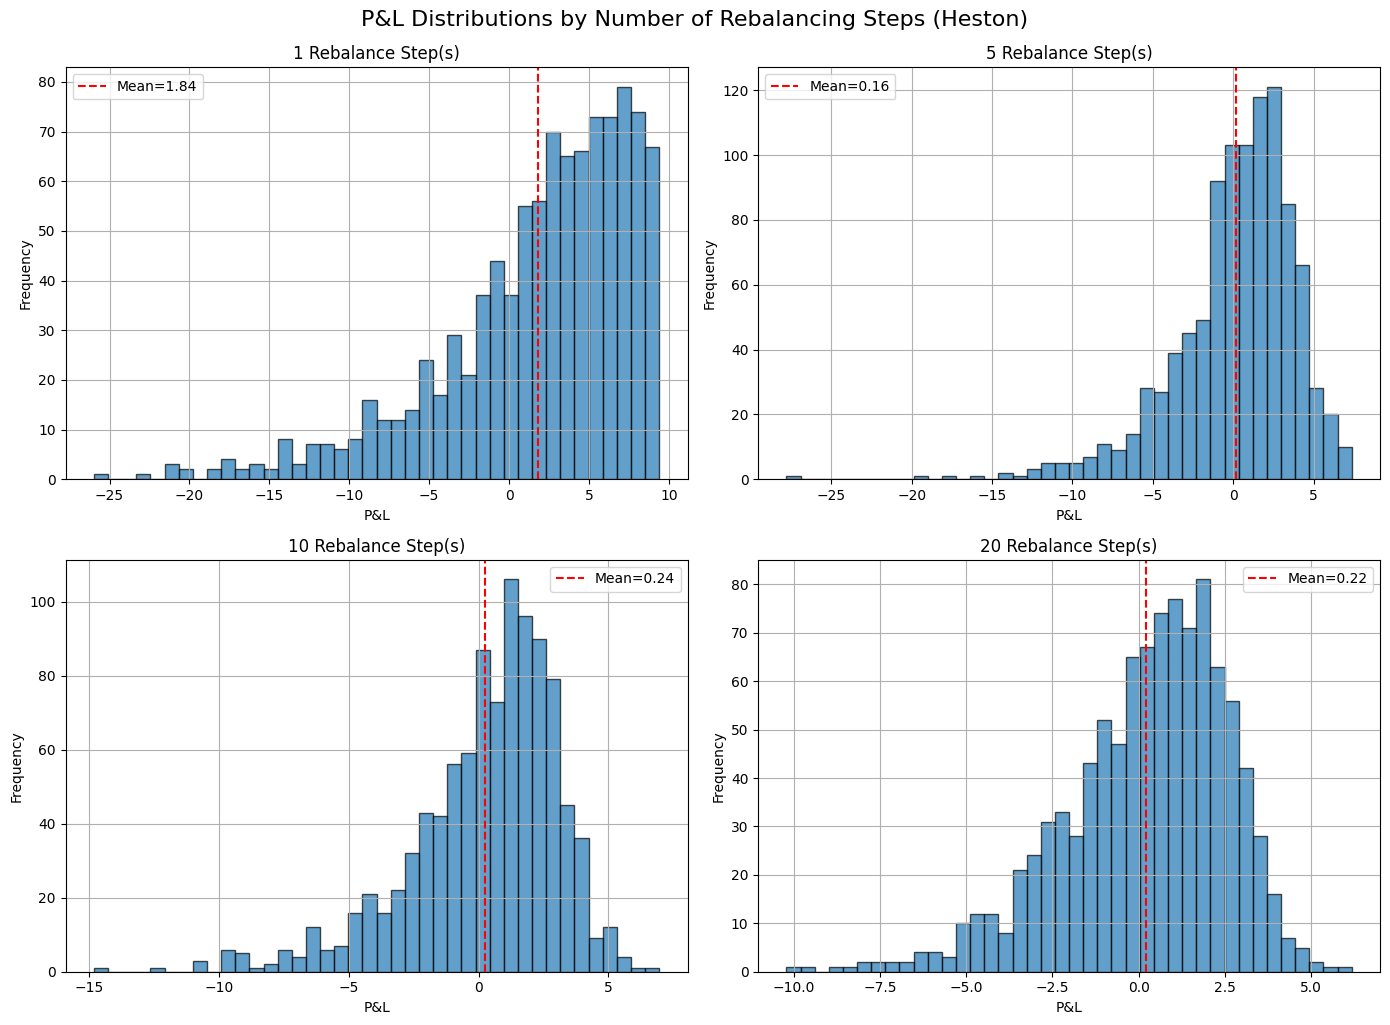

,Steps,Mean P&L,Std Dev,Min P&L,Max P&L
0,1,1.837464,6.006297,-25.979896,9.399184
1,5,0.162614,3.805883,-27.792696,7.378607
2,10,0.235480,2.884757,-14.812865,6.959384
3,20,0.216361,2.399100,-10.217514,6.185182


In [3]:
#Different hedge steps
import pandas as pd

hedge_steps_list = [1,5, 10, 20]
pnl_results = {}

for steps in hedge_steps_list:
    pnl = delta_hedging_heston(S_paths, v_paths, K, r, T, rebalance_steps=steps)
    pnl_results[steps] = pnl

#plot histograms
plt.figure(figsize=(14,10))

for i, steps in enumerate(hedge_steps_list):
    plt.subplot(2,2,i+1)
    plt.hist(pnl_results[steps],bins=40,edgecolor='black',alpha=0.7)
    plt.axvline(np.mean(pnl_results[steps]), color = 'red', linestyle = '--', label = f"Mean={np.mean(pnl_results[steps]):.2f}")
    plt.title(f"{steps} Rebalance Step(s)")
    plt.xlabel("P&L")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("P&L Distributions by Number of Rebalancing Steps (Heston)", fontsize = 16, y = 1.02)
plt.show()

summary = pd.DataFrame({
    "Steps": hedge_steps_list,
    "Mean P&L": [np.mean(pnl_results[s]) for s in hedge_steps_list],
    "Std Dev": [np.std(pnl_results[s]) for s in hedge_steps_list],
    "Min P&L": [np.min(pnl_results[s]) for s in hedge_steps_list],
    "Max P&L": [np.max(pnl_results[s]) for s in hedge_steps_list],
})

summary


### Comparison with GBM Model (Constant Volatility)

C:\Users\andre\AppData\Local\Temp\ipykernel_53308\2841759563.py:9: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


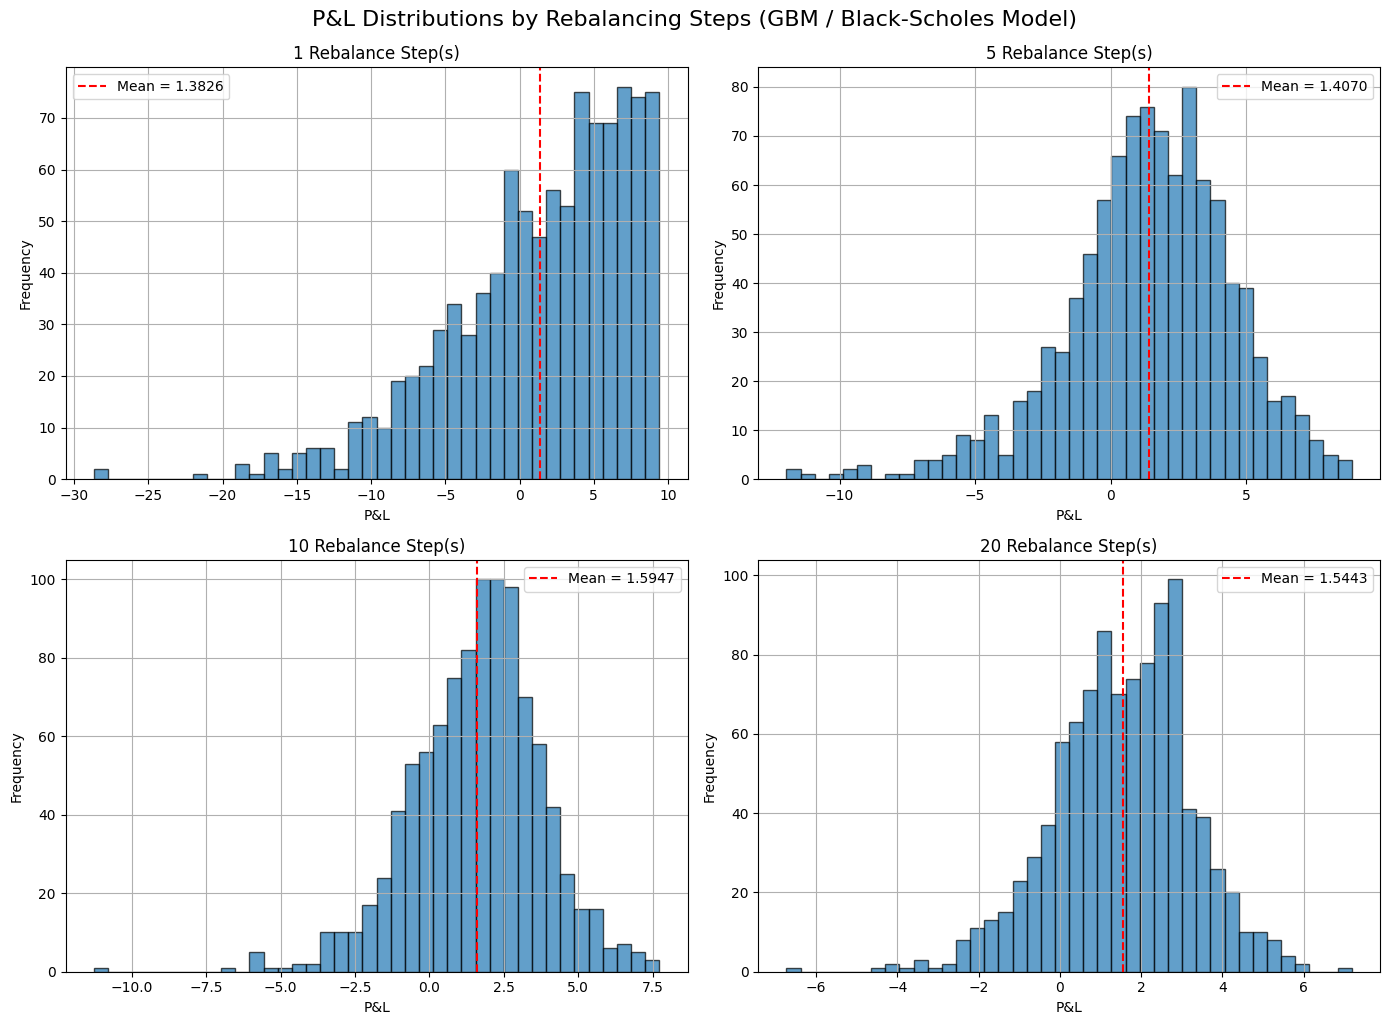

,Steps,Mean P&L,Std Dev
0,1,1.382583,6.070642
1,5,1.406964,3.110736
2,10,1.594735,2.181062
3,20,1.544341,1.678384


In [5]:
def simulate_gbm_paths(S0, r, sigma, T, N, M):
    dt = T/ N
    Z = np.random.normal(0, 1, (M, N))
    S = np.zeros((M, N+1))
    S[:, 0] = S0 

    for t in range(1, N+1):
        S[:, t ] = S[:, t-1] * np.exp((r - 0.5 * sigma **2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])

    return S

def delta_hedging_gbm(S_paths, K, sigma, r, T, rebalance_steps = 10):
    M, N_plus_1 = S_paths.shape
    N = N_plus_1 -1
    dt = T/N
    rebalance_indices = np.linspace(0, N, rebalance_steps + 1, dtype = int)

    option_premium = bs_call_price(S_paths[:, 0], K, sigma, T,r)
    cash_account = option_premium.copy()
    stock_position = bs_delta_call(S_paths[:, 0], K, sigma, T, r)
    cash_account -= stock_position *S_paths[:, 0]

    for i in range(1, len(rebalance_indices)):
        t_idx_prev = rebalance_indices[i-1]
        t_idx = rebalance_indices[i]
        tau = T - t_idx * dt

        new_delta = bs_delta_call(S_paths[:, t_idx], K, sigma, tau, r)
        delta_change = new_delta - stock_position
        cash_account -= delta_change * S_paths[:, t_idx]
        stock_position = new_delta

    #liquidate hedge
    final_stock_value = stock_position * S_paths[:, -1]
    final_option_payoff = np.maximum(S_paths[:, -1] - K, 0)
    pnl = cash_account + final_stock_value - final_option_payoff
    return pnl


sigma_bs = 0.2  # Constant vol used in GBM
gbm_paths = simulate_gbm_paths(S0, r, sigma_bs, T, N, M)

# Compare multiple rebalancing frequencies
gbm_pnl_results = {}
for steps in hedge_steps_list:  # [1, 5, 10, 20]
    pnl = delta_hedging_gbm(gbm_paths, K, sigma_bs, r, T, rebalance_steps=steps)
    gbm_pnl_results[steps] = pnl

# Plot histograms
plt.figure(figsize=(14, 10))
for i, steps in enumerate(hedge_steps_list):
    plt.subplot(2, 2, i+1)
    plt.hist(gbm_pnl_results[steps], bins=40, edgecolor='black', alpha=0.7)
    plt.axvline(np.mean(gbm_pnl_results[steps]), color='red', linestyle='--', label=f"Mean = {np.mean(gbm_pnl_results[steps]):.4f}")
    plt.title(f"{steps} Rebalance Step(s)")
    plt.xlabel("P&L")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("P&L Distributions by Rebalancing Steps (GBM / Black-Scholes Model)", fontsize=16, y=1.02)
plt.show()

# Print summary stats
pd.DataFrame({
    "Steps": hedge_steps_list,
    "Mean P&L": [np.mean(gbm_pnl_results[s]) for s in hedge_steps_list],
    "Std Dev": [np.std(gbm_pnl_results[s]) for s in hedge_steps_list]
})

### Evaluate Hedging Error Over Time

C:\Users\andre\AppData\Local\Temp\ipykernel_53308\2841759563.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
C:\Users\andre\AppData\Local\Temp\ipykernel_53308\1057158887.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S0/K)+(r+0.5*sigma**2)*t) / (sigma * np.sqrt(t))


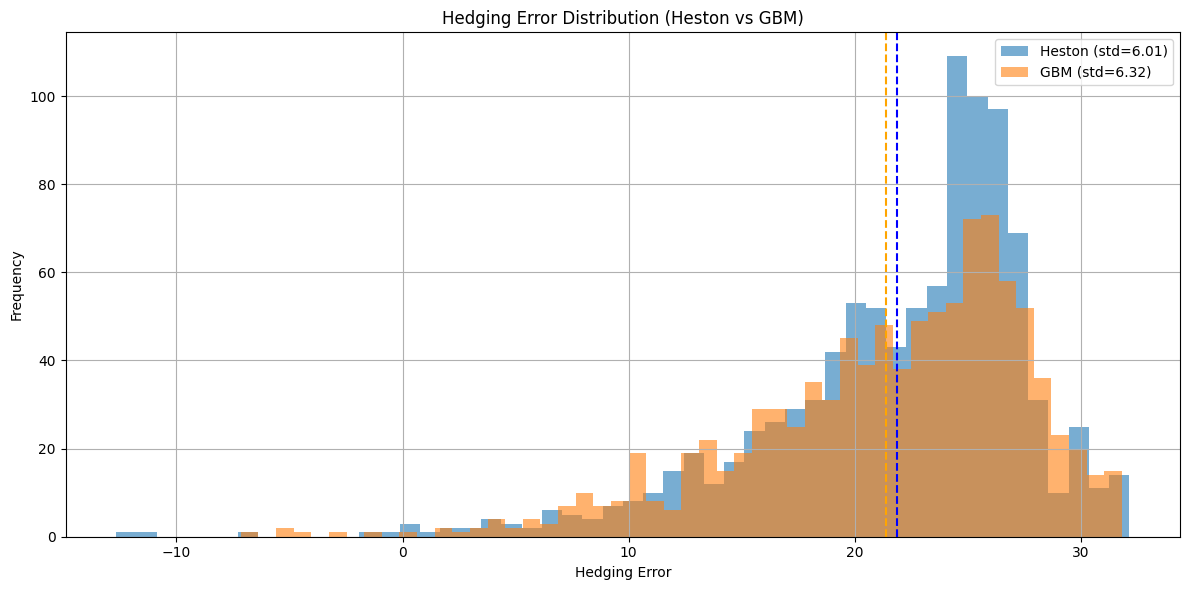

In [7]:
import numpy as np

def simulate_heston_paths(S0, v0, kappa, theta, sigma_v, rho, r, T, N, M):
    dt = T / N
    S = np.zeros((M, N+1))
    v = np.zeros((M, N+1))
    S[:, 0] = S0
    v[:, 0] = v0

    for t in range(1, N+1):
        Z1 = np.random.normal(size=M)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(size=M)

        v[:, t] = np.abs(
            v[:, t-1] + kappa * (theta - v[:, t-1]) * dt +
            sigma_v * np.sqrt(v[:, t-1] * dt) * Z2
        )
        S[:, t] = S[:, t-1] * np.exp(
            (r - 0.5 * v[:, t-1]) * dt + np.sqrt(v[:, t-1] * dt) * Z1
        )

    return S, v

def simulate_gbm_paths(S0, sigma, r, T, N, M):
    dt = T / N
    S = np.zeros((M, N+1))
    S[:, 0] = S0

    for t in range(1, N+1):
        Z = np.random.normal(size=M)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    return S

def bs_call(S0, K, sigma, t=1, r = 0):
    d1 = (np.log(S0/K)+(r+0.5*sigma**2)*t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return S0 * norm.cdf(1) - K * np.exp(-r*t) * norm.cdf(d2)


def hedging_error_over_time(S_paths, v_paths, K, r, T, rebalance_steps):
    N=S_paths.shape[1] - 1
    dt = T/N
    rebalance_indices = np.linspace(0, N, rebalance_steps + 1, dtype = int)
    M = S_paths.shape[0]

    final_errors = []

    for i in range(M):
        S = S_paths[i]
        v = v_paths[i]
        cash = []
        stock = []

        #Initial delta + premium
        delta = bs_delta_call(S[0], K, np.sqrt(v[0]), T, r)
        call_price = bs_call(S[0], K, np.sqrt(v[0]), T, r)
        cash_val = call_price - delta * S[0]

        for j in range(1, len(rebalance_indices)):
            t_idx = rebalance_indices[j]
            t_prev = rebalance_indices[j-1]
            t = t_idx * dt
            tau = T - T

            new_delta = bs_delta_call(S[t_idx], K, np.sqrt(v[t_idx]), tau, r)
            portfolio_value = cash_val * np.exp(r * (t_idx - t_prev) *dt) + delta * S[t_idx]
            true_call = bs_call(S[t_idx], K, np.sqrt(v[t_idx]), tau, r)
            
            cash_val = portfolio_value - new_delta * S[t_idx]
            delta = new_delta

        # At maturity
        final_portfolio_value = cash_val * np.exp(r * (N - rebalance_indices[-1]) * dt) + delta * S[N]
        actual_option_value = max(S[N] - K, 0)
        error = final_portfolio_value - actual_option_value
        final_errors.append(error)
    return np.array(final_errors)

# Parameters
S0 = 100
v0 = 0.04
kappa = 2
theta = 0.04
sigma_v = 0.5
rho = -0.7
r = 0.05
T = 1
N = 252
M = 1000

S_heston, v_heston = simulate_heston_paths(S0, v0, kappa, theta, sigma_v, rho, r, T, N, M)

sigma = 0.2

S_gbm = simulate_gbm_paths(S0, sigma, r, T, N, M)
v_gbm = np.full_like(S_gbm, sigma**2)  # constant volatility squared



# Hedging error for both models
K = 100
rebalance_steps = 10

errors_heston = hedging_error_over_time(S_heston, v_heston, K, r, T, rebalance_steps)
errors_gbm = hedging_error_over_time(S_gbm, v_gbm, K, r, T, rebalance_steps)

# Plot
plt.figure(figsize=(12, 6))
plt.hist(errors_heston, bins=50, alpha=0.6, label=f'Heston (std={np.std(errors_heston):.2f})')
plt.hist(errors_gbm, bins=50, alpha=0.6, label=f'GBM (std={np.std(errors_gbm):.2f})')
plt.axvline(np.mean(errors_heston), color='blue', linestyle='--')
plt.axvline(np.mean(errors_gbm), color='orange', linestyle='--')
plt.title("Hedging Error Distribution (Heston vs GBM)")
plt.xlabel("Hedging Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Vega Hedging

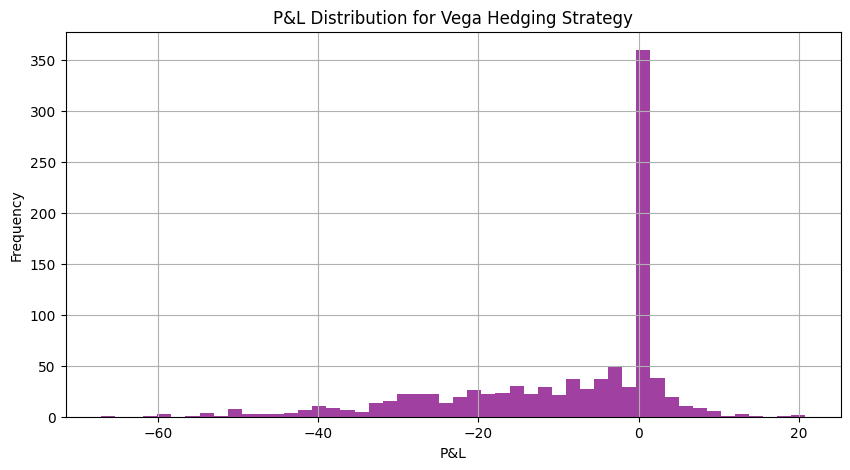

In [8]:
from scipy.stats import norm

#BS delta and Vega for a call option

def bs_delta_call(S, K, sigma, t, T, r):
    tau = T - t 
    if tau <= 0:
        return 0.0
    d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    return norm.cdf(d1)

def bs_vega(S, K, sigma, t, T, r):
    tau = T - t 
    if tau <= 0:
        return 0.0
    d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2 ) * tau) / (sigma * np.sqrt(tau))
    return S * norm.pdf(d1) * np.sqrt(tau)

def bs_call_price(S, K, sigma, tau, r):
    if tau <= 0:
        return max(S-K, 0)
    d1 = (np.log(S/K) + (r + 0.5 * sigma **2)*tau)/(sigma*np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S*norm.cdf(d1) - K*np.exp(-r*tau)*norm.cdf(d2)


#Vega hedging

def vega_hedging_heston(S_paths, v_paths, K_main, K_hedge, r, T, rebalance_steps):
    M, N_plus_1 = S_paths.shape
    N = N_plus_1 -1
    dt = T / N
    rebalance_indices = np.linspace(0, N, rebalance_steps + 1, dtype = int)

    pnl_all = []

    for path_idx in range(M):
        S = S_paths[path_idx]
        v = v_paths[path_idx]

        cash = 0.0
        x_stock = 0.0
        y_optB = 0.0

        for i in range(len(rebalance_indices)-1):
            t_idx = rebalance_indices[i]
            t = t_idx * dt
            S_t = S[t_idx]
            sigma_t = np.sqrt(v[t_idx])

            #Greeks for option A (ATM)

            delta_A = bs_delta_call(S_t, K_main, sigma_t, t, T, r)
            vega_A = bs_vega(S_t, K_main, sigma_t, t, T, r)

            #Greeks for Option B

            delta_B = bs_delta_call(S_t, K_hedge, sigma_t, t, T, r)
            vega_B = bs_vega(S_t, K_hedge, sigma_t, t, T, r)

            #Solve linear system
            A = np.array([[1,delta_B],[0,vega_B]])
            b = np.array([-delta_A, -vega_A])

            try:
                x_stock, y_optB = np.linalg.solve(A,b)
            except:
                x_stock, y_optB = 0.0, 0.0

            #Rebalance: compute new cash

            price_B = bs_call_price(S_t, K_hedge, sigma_t, T-t,r)
            cash = -x_stock *S_t - y_optB * price_B

        #At maturity
        S_T = S[-1]
        payoff_A = max(S_T - K_main, 0)
        payoff_B = max(S_T - K_hedge, 0)
        portfolio_value = x_stock * S_T + y_optB * payoff_B + cash
        pnl = portfolio_value - payoff_A
        pnl_all.append(pnl)

    return np.array(pnl_all)


K_main = 100          # ATM call
K_hedge = 110         # OTM call (vega hedge)
r = 0.05
T = 1
rebalance_steps = 10

pnl_vega = vega_hedging_heston(S_paths, v_paths, K_main, K_hedge, r, T, rebalance_steps)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(pnl_vega, bins=50, alpha=0.75, color='purple')
plt.title("P&L Distribution for Vega Hedging Strategy")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Machine Learing: Hedging Classification

In [10]:
from scipy.stats import norm
#Dataset construction
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import norm
import seaborn as sns

def bs_delta_call(S, K, sigma, T, r):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def compute_hedging_error(S_path, v_path, K, r, T, rebalance_steps):
    N = len(S_path) - 1
    rebalance_indices = np.linspace(0, N, rebalance_steps + 1, dtype=int)
    dt = T / N

    option_payoff = max(S_path[-1] - K, 0)
    option_price = np.exp(-r * T) * option_payoff

    cash = option_price
    shares = bs_delta_call(S_path[0], K, np.sqrt(v_path[0]), T, r)
    cash -= shares * S_path[0]

    for i in range(1, len(rebalance_indices)):
        t_prev = rebalance_indices[i - 1]
        t_now = rebalance_indices[i]
        ttm = (N - t_now) * dt

        sigma_t = np.sqrt(v_path[t_now])
        delta_now = bs_delta_call(S_path[t_now], K, sigma_t, max(ttm, 1e-6), r)
        delta_change = delta_now - shares
        cash -= delta_change * S_path[t_now]
        shares = delta_now

    portfolio_value = shares * S_path[-1] + cash * np.exp(r * T)
    hedging_error = portfolio_value - option_payoff
    return hedging_error

def get_hedging_dataset(S_paths, v_paths, K, r, T, rebalance_steps, threshold = 2.0):
    features = []
    labels = []

    for i in range(len(S_paths)):
        S = S_paths[i]
        v = v_paths[i]
        error = compute_hedging_error(S, v, K, r, T, rebalance_steps)

        final_price = S[-1]
        realized_vol = np.mean(v)
        moneyness = final_price / K
        initial_vol = v[0]

        features.append([final_price, realized_vol, moneyness, initial_vol])
        labels.append(int(abs(error) <= threshold))

    return np.array(features), np.array(labels)


S0 = 100
v0 = 0.04
kappa = 2.0
K = 100
theta = 0.04
sigma_v = 0.3
rho = -0.7
r = 0.05
T = 1

#Simulate paths
#S_paths, v_paths = simulate_heston_paths(S0, v0, kappa, theta, sigma_v, rho, r, T, N, M)

S0, v0, K, r, T = 100, 0.04, 100, 0.05, 1
heston_params = params = {
    "S0": 100,
    "v0": 0.04,
    "kappa": 2.0,
    "theta": 0.04,
    "sigma_v": 0.3,
    "rho": -0.7,
    "r": 0.05,
    "T": 1,
    "N": 100,
    "M": 5000
}


S_paths, v_paths = simulate_heston_paths(**heston_params)
X, y = get_hedging_dataset(S_paths, v_paths, K, r, T, rebalance_steps=10)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)
model = LogisticRegression(max_iter = 1000, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=False)
conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix

array([[817, 568],
       [  7, 108]], dtype=int64)

### Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

#Confusion matrix
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)
rf_cm_df = pd.DataFrame(rf_conf_matrix, index = ["Actual 0 (High Error)", "Actual 1 (Low Error)"], columns = ["Predicted 0", "Predicted 1"])

#Classification report and feature importance
rf_report = classification_report(y_test, y_pred_rf, output_dict = True)
feature_importance = rf_model.feature_importances_
feature_labels = ["Final Price", "Realized Vol", "Moneyness", "Initial Vol"]
importance_df = pd.DataFrame({"Feature": feature_labels, "Importance": feature_importance}).sort_values(by="Importance",ascending=False)

rf_report, importance_df

({'0': {'precision': 0.9690869877785766,
   'recall': 0.9732851985559566,
   'f1-score': 0.9711815561959655,
   'support': 1385.0},
  '1': {'precision': 0.6605504587155964,
   'recall': 0.6260869565217392,
   'f1-score': 0.6428571428571429,
   'support': 115.0},
  'accuracy': 0.9466666666666667,
  'macro avg': {'precision': 0.8148187232470865,
   'recall': 0.7996860775388479,
   'f1-score': 0.8070193495265542,
   'support': 1500.0},
  'weighted avg': {'precision': 0.9454325205504148,
   'recall': 0.9466666666666667,
   'f1-score': 0.9460100178399891,
   'support': 1500.0}},
         Feature  Importance
 0   Final Price    0.452017
 2     Moneyness    0.418988
 1  Realized Vol    0.128995
 3   Initial Vol    0.000000)

### XGBoost

In [12]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

#Initialize model
xgb_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y == 0).sum() / (y==1).sum(), #Handle imbalance
    random_state = 42
)

#Train the model
xgb_model.fit(X_train, y_train)

#predict
y_pred_xgb = xgb_model.predict(X_test)

#Confusion Matrix
xgb_conf_matrix = confusion_matrix(y_test, y_pred_xgb)
xgb_cm_df = pd.DataFrame(xgb_conf_matrix, index = ["Actual 0 (High Error)", "Actual 1 (Low Error)"],
                         columns = ["Predicted 0", "Predicted 1"])

#classification report
xgb_report = classification_report(y_test, y_pred_xgb, output_dict=True)

#Feature importances
xgb_importance = xgb_model.feature_importances_
feature_labels = ["Final Price", "Realized Vol", "Moneyness", "Initial Vol"]
importance_df = pd.DataFrame({
    "Feature": feature_labels,
    "Importance": xgb_importance
}).sort_values(by="Importance", ascending=False)

xgb_report, importance_df


c:\Users\andre\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


({'0': {'precision': 0.9804804804804805,
   'recall': 0.9429602888086642,
   'f1-score': 0.9613544350386456,
   'support': 1385.0},
  '1': {'precision': 0.5297619047619048,
   'recall': 0.7739130434782608,
   'f1-score': 0.6289752650176679,
   'support': 115.0},
  'accuracy': 0.93,
  'macro avg': {'precision': 0.7551211926211927,
   'recall': 0.8584366661434626,
   'f1-score': 0.7951648500281567,
   'support': 1500.0},
  'weighted avg': {'precision': 0.9459253896753897,
   'recall': 0.93,
   'f1-score': 0.935872032003704,
   'support': 1500.0}},
         Feature  Importance
 0   Final Price    0.861664
 1  Realized Vol    0.138336
 2     Moneyness    0.000000
 3   Initial Vol    0.000000)

## Volatility Clustering

<Figure size 1000x400 with 0 Axes>

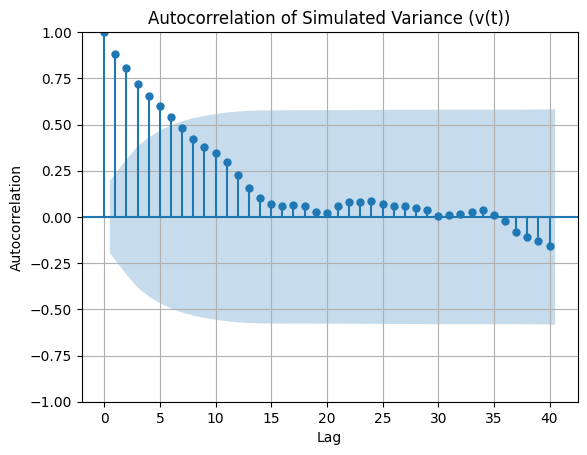

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf

v_sample = v_paths[0]

plt.figure(figsize=(10,4))
plot_acf(v_sample, lags = 40)
plt.title("Autocorrelation of Simulated Variance (v(t))")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()


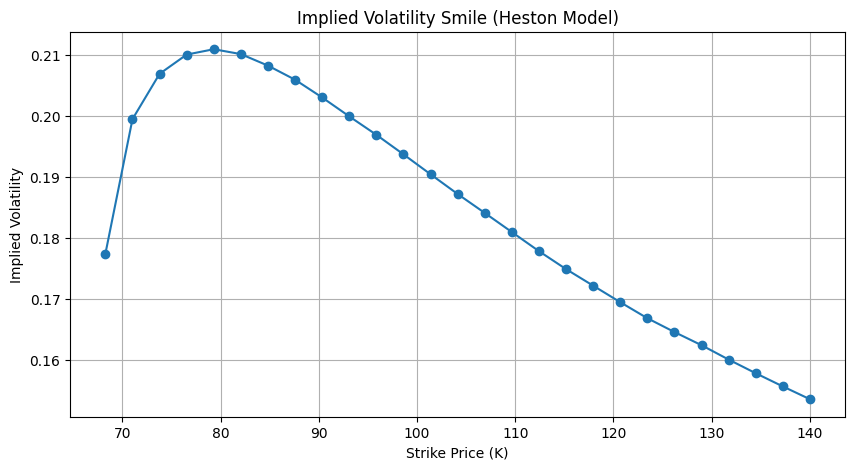

In [33]:
from scipy.optimize import brentq
from scipy.stats import norm

# Black-Scholes Call Price Formula
def bs_call_price(S, K, sigma, T, r):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Implied Volatility Solver for Calls
def implied_volatility_call(price, S, K, T, r, tol=1e-6):
    try:
        return brentq(lambda sigma: bs_call_price(S, K, sigma, T, r) - price, 1e-6, 5, xtol=tol)
    except ValueError:
        return np.nan  # if no solution found

# Assume you have these
S0 = 100
v0 = 0.04
r = 0.05
T = 1.0  # 1 year
K_values = np.linspace(60, 140, 30)  # Range of strike prices

# Heston simulation parameters
heston_params = {
    "S0": S0,
    "v0": v0,
    "kappa": 2.0,
    "theta": 0.04,
    "sigma_v": 0.3,
    "rho": -0.7,
    "r": r,
    "T": T,
    "N": 100,
    "M": 10000
}

# Simulate stock paths
S_paths, v_paths = simulate_heston_paths(**heston_params)
S_T = S_paths[:, -1]  # terminal prices

# Compute Heston call prices for each strike
call_prices = [np.mean(np.maximum(S_T - K, 0)) * np.exp(-r * T) for K in K_values]

# Calculate IVs from the call prices
iv_values = [implied_volatility_call(price, S0, K, T, r) for price, K in zip(call_prices, K_values)]

# Plot the Smile
plt.figure(figsize=(10, 5))
plt.plot(K_values, iv_values, marker='o')
plt.title("Implied Volatility Smile (Heston Model)")
plt.xlabel("Strike Price (K)")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()

